In [3]:
import numpy as np
import pandas as pd
import scripts as sc
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

## Metoda średniego zwrotu (Mean Return Model)

To najprostsza metoda, polegająca na obliczeniu średniego dziennego zwrotu z wybranego okresu przed incydentem.

Krok 1: Zbieranie danych

Zbierz historyczne dane cen akcji za okres np. 30-60 dni przed incydentem.

Krok 2: Obliczenie dziennych zwrotów

Dzienny zwrot ($R_t$) dla każdego dnia obliczysz za pomocą wzoru:
$$
R_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \ln\left(\frac{P_t}{P_{t-1}}\right)
$$
Gdzie:

$R_t$ to dzienny zwrot w dniu $t$,

$P_t$ to cena zamknięcia akcji w dniu $t$,

$P_{t-1}$ to cena zamknięcia akcji w dniu poprzedzającym $t$.


Krok 3: Obliczenie średniego zwrotu

Średni zwrot z okresu przed incydentem obliczasz jako:
$$
\overline{R} = \frac{1}{N} \sum_{t=1}^{N} R_t
$$
Gdzie:

$N$ to liczba dni w okresie przed incydentem,

$R_t$ to zwroty z każdego dnia.


Krok 4: Prognozowanie zwrotów normalnych
Załóżmy, że normalny dzienny zwrot w okresie po incydencie będzie równy temu średniemu zwrotowi. Zwrot normalny w dniu $t$ po incydencie wynosi:
$$
\text{Zwrot normalny}_t = \overline{R}
$$

In [2]:
report_database = pd.read_csv("../database/mergedData/Annual_V.csv", index_col=[0])

## Model rynkowy (Market Model)
---

Ta metoda jest bardziej zaawansowana, ponieważ bierze pod uwagę ruchy całego rynku (np. indeks giełdowy).

Krok 1: Wybór indeksu rynkowego

Wybierz odpowiedni indeks rynkowy, np. WIG20, S\&P 500 itp., który będzie służył jako benchmark.

Krok 2: Obliczenie dziennych zwrotów dla akcji i indeksu

Oblicz dzienne zwroty zarówno dla akcji, jak i dla wybranego indeksu w okresie przed incydentem (tak jak w kroku 2 metody średniego zwrotu).

Krok 3: Regresja liniowa

Przeprowadź regresję liniową, gdzie:
$$
R_t = \alpha + \beta R_{M,t} + \epsilon_t
$$
Gdzie:

$R_t$ to dzienny zwrot akcji w dniu $t$,

$R_{M,t}$ to dzienny zwrot indeksu rynkowego w dniu $t$,

$\alpha$ to stała (intercept),

$\beta$ to współczynnik nachylenia (slope),

$\epsilon_t$ to składnik losowy (residual).


Krok 4: Prognozowanie zwrotów normalnych
Dla każdego dnia po incydencie prognozowany zwrot normalny obliczasz za pomocą wzoru:
$$
\text{Zwrot normalny}_t = \alpha + \beta R_{M,t}
$$


#### Przyjęte założenia 

Okno czasowe do wyznaczenie współczynników 30 dni giełdowych $t_{-60}...t_{-30}$

In [4]:
# Read database with financial report
report_database = pd.read_csv("../database/mergedData/Annual_V.csv", index_col=[0])
cr = sc.CompanyReturn()
ir = sc.IndexReturn()

In [9]:
WINDOW_PAST = 60
WINDOW_SIZE = 30

ANALYSIS_RANGE = 10
columns_name = [f"t{i}" for i in range(-ANALYSIS_RANGE,ANALYSIS_RANGE)]
mm_df = pd.DataFrame(columns=columns_name)

lr_model = LinearRegression()

for idx, row in report_database.iterrows():
    ticker = row["Ticker"]
    date = row["Data"]
    cr.readHistorical(ticker)
    ir.readHistorical(cr.getIndexTick(ticker))
    company_value = cr.getHistoricalData(date, WINDOW_PAST, ANALYSIS_RANGE)
    index_value = ir.getHistoricalData(date, WINDOW_PAST, ANALYSIS_RANGE)

    if company_close_value.empty or index_close_value.empty:
        continue

    if company_close_value.shape[0] != index_close_value.shape[0]:
        continue

    company_close_value = company_value["Close"].to_numpy()
    index_close_value = index_value["Close"].to_numpy()

    lr_model.fit(index_close_value[:WINDOW_SIZE].reshape(-1, 1), 
                 company_close_value[:WINDOW_SIZE].reshape(-1, 1))


In [9]:
model = LinearRegression()
model.fit(ir_close_value[:60].to_numpy().reshape(-1, 1), 
          cr_close_value[:60].to_numpy().reshape(-1, 1))

LinearRegression()

In [10]:
y_pred = model.predict(ir_close_value[:60].to_numpy().reshape(-1, 1))

# Obliczenie R-kwadrat.
r2 = r2_score(cr_close_value[:60].to_numpy().reshape(-1, 1), y_pred)

print("R kwadrat:", r2)

R kwadrat: 0.5725056477878581


In [11]:
a = model.coef_
print("Współczynnik a:", a)

# Współczynnik b w równaniu y = a*x + b
b = model.intercept_
print("Współczynnik b:", b)

Współczynnik a: [[0.00475119]]
Współczynnik b: [-5.05541315]


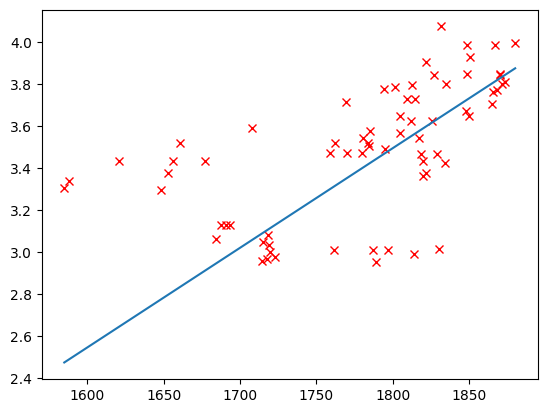

In [12]:
import matplotlib.pyplot as plt

plt.plot(ir_close_value, cr_close_value, "rx")
plt.plot(np.linspace(ir_close_value.min(),ir_close_value.max(),100).reshape(-1, 1),
         (a*np.linspace(ir_close_value.min(),ir_close_value.max(),100)+b).reshape(-1, 1))
plt.show()